# Plot phase space trajectories

In [1]:
import importlib
from itertools import combinations
from urllib.request import urlopen

import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pylab as plt
from jax import vmap
from matplotlib.colors import hsv_to_rgb
from sbmltoodejax.modulegeneration import GenerateModel
from sbmltoodejax.parse import ParseSBMLFile

## Utils 

In [2]:
def generate_model(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):

    model_jax_file = "jax_model.py"
    model_url = f"https://www.ebi.ac.uk/biomodels/model/download/BIOMD{model_idx:010d}.2?filename=BIOMD{model_idx:010d}_url.xml"
    with urlopen(model_url) as response:
        model_xml_body = response.read().decode("utf-8")
    model_data = ParseSBMLFile(model_xml_body)
    GenerateModel(
        model_data,
        model_jax_file,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    return model_jax_file


def load_model(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):
    model_jax_filepath = generate_model(
        model_idx,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    spec = importlib.util.spec_from_file_location("JaxModelSpec", model_jax_filepath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    model_cls = getattr(module, "ModelRollout")
    model = model_cls()
    y0 = getattr(module, "y0")
    w0 = getattr(module, "w0")

    return model, y0, w0

In [3]:
def plot_time_trajectories(times, ys, y_ids, y_labels):
    plt.figure(figsize=(10, 7))
    for y_idx, y_label in zip(y_ids, y_labels):
        plt.plot(times, ys[y_idx], label=y_label)
    plt.legend()
    plt.show()

    return

In [4]:
def plot_batched_time_trajectories(times, ys, y_ids, y_labels):

    plt.figure(figsize=(10, 7))
    for y_idx, y_label in zip(y_ids, y_labels):
        mean_curve = ys[:, y_idx, :].mean(0)
        std_curve = ys[:, y_idx, :].std(0)
        plt.plot(times, mean_curve, label=y_label)
        plt.fill_between(
            times, mean_curve - std_curve, mean_curve + std_curve, alpha=0.5
        )
    plt.legend()
    plt.show()

    return

In [5]:
def plot_phase_space_trajectories(
    ys, y_indexes, y1_labels=None, y2_labels=None, zoom=7, plot_every=1
):

    if y1_labels is None:
        combins = list(combinations(y_indexes.keys(), 2))
        y1_labels = [c[0] for c in combins]
        y2_labels = [c[1] for c in combins]

    y1_ids = [y_indexes[y1_label] for y1_label in y1_labels]
    y2_ids = [y_indexes[y2_label] for y2_label in y2_labels]

    plot_time_trajectories(
        times,
        ys,
        list(y_indexes.values()),
        list(y_indexes.keys()),
    )

    n_rows = int(jnp.sqrt(len(y1_ids)))
    n_cols = n_rows + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * zoom, n_rows * zoom))

    fig_idx = 0
    for rel_idx, (y1_idx, y2_idx) in enumerate(zip(y1_ids, y2_ids)):
        X = ys[y1_idx, :-1][::plot_every]

        Y = ys[y2_idx, :-1][::plot_every]

        U = ys[y1_idx, 1:][::plot_every] - ys[y1_idx, :-1][::plot_every]

        V = ys[y2_idx, 1:][::plot_every] - ys[y2_idx, :-1][::plot_every]

        c = [hsv_to_rgb((step / len(X), 1, 1)) for step in range(len(X))]

        if n_rows > 1:

            row_idx, col_idx = jnp.unravel_index(fig_idx, (n_rows, n_cols))
            ax[row_idx, col_idx].quiver(X, Y, U, V, color=c)
            ax[row_idx, col_idx].set_xlabel(y1_labels[rel_idx])
            ax[row_idx, col_idx].set_ylabel(y2_labels[rel_idx])

        else:
            ax[fig_idx].quiver(X, Y, U, V, color=c)
            ax[fig_idx].set_xlabel(y1_labels[rel_idx])
            ax[fig_idx].set_ylabel(y2_labels[rel_idx])

        fig_idx += 1

    for empty_fig_idx in range(fig_idx, n_rows * n_cols):
        if n_rows > 1:
            row_idx, col_idx = jnp.unravel_index(empty_fig_idx, (n_rows, n_cols))
            ax[row_idx, col_idx].axis("off")
        else:
            ax[empty_fig_idx].axis("off")

        empty_fig_idx += 1

    fig.suptitle("Phase space trajectories")
    fig.show()

    return

In [6]:
def plot_batched_phase_space_trajectories(
    ys, y_indexes, y1_labels=None, y2_labels=None, zoom=7, plot_every=1
):

    if y1_labels is None:
        combins = list(combinations(y_indexes.keys(), 2))
        y1_labels = [c[0] for c in combins]
        y2_labels = [c[1] for c in combins]

    y1_ids = [y_indexes[y1_label] for y1_label in y1_labels]
    y2_ids = [y_indexes[y2_label] for y2_label in y2_labels]

    plot_batched_time_trajectories(
        times,
        ys,
        list(y_indexes.values()),
        list(y_indexes.keys()),
    )

    n_rows = int(jnp.sqrt(len(y1_ids)))
    n_cols = n_rows + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * zoom, n_rows * zoom))

    fig_idx = 0
    for rel_idx, (y1_idx, y2_idx) in enumerate(zip(y1_ids, y2_ids)):

        X = ys[:, y1_idx, :-1][::plot_every]

        Y = ys[:, y2_idx, :-1][::plot_every]

        U = ys[:, y1_idx, 1:][::plot_every] - ys[:, y1_idx, :-1][::plot_every]

        V = ys[:, y2_idx, 1:][::plot_every] - ys[:, y2_idx, :-1][::plot_every]

        c = [hsv_to_rgb((step / X.shape[1], 1, 1)) for step in range(X.shape[1])]

        if n_rows > 1:

            row_idx, col_idx = jnp.unravel_index(fig_idx, (n_rows, n_cols))
            for init_idx in range(ys.shape[0]):
                ax[row_idx, col_idx].quiver(
                    X[init_idx], Y[init_idx], U[init_idx], V[init_idx], color=c
                )
            ax[row_idx, col_idx].set_xlabel(y1_labels[rel_idx])
            ax[row_idx, col_idx].set_ylabel(y2_labels[rel_idx])

        else:
            for init_idx in range(ys.shape[0]):
                ax[fig_idx].quiver(
                    X[init_idx], Y[init_idx], U[init_idx], V[init_idx], color=c
                )
            ax[fig_idx].set_xlabel(y1_labels[rel_idx])
            ax[fig_idx].set_ylabel(y2_labels[rel_idx])

        fig_idx += 1

    for empty_fig_idx in range(fig_idx, n_rows * n_cols):
        if n_rows > 1:
            row_idx, col_idx = jnp.unravel_index(empty_fig_idx, (n_rows, n_cols))
            ax[row_idx, col_idx].axis("off")
        else:
            ax[empty_fig_idx].axis("off")

        empty_fig_idx += 1

    fig.suptitle("Phase space trajectories")
    fig.show()

    return

In [7]:
n_secs = 100

## Analysis of Model 8

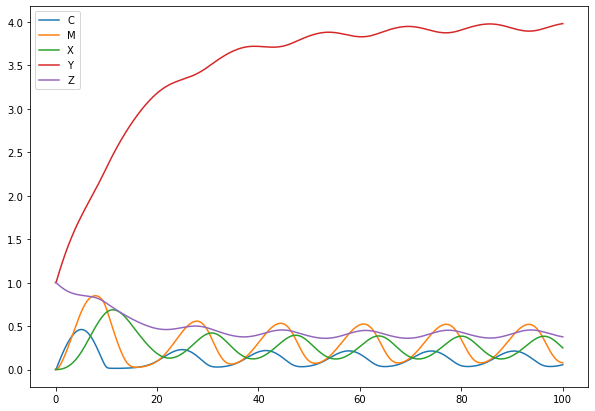

/tmp/ipykernel_20305/1213235191.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


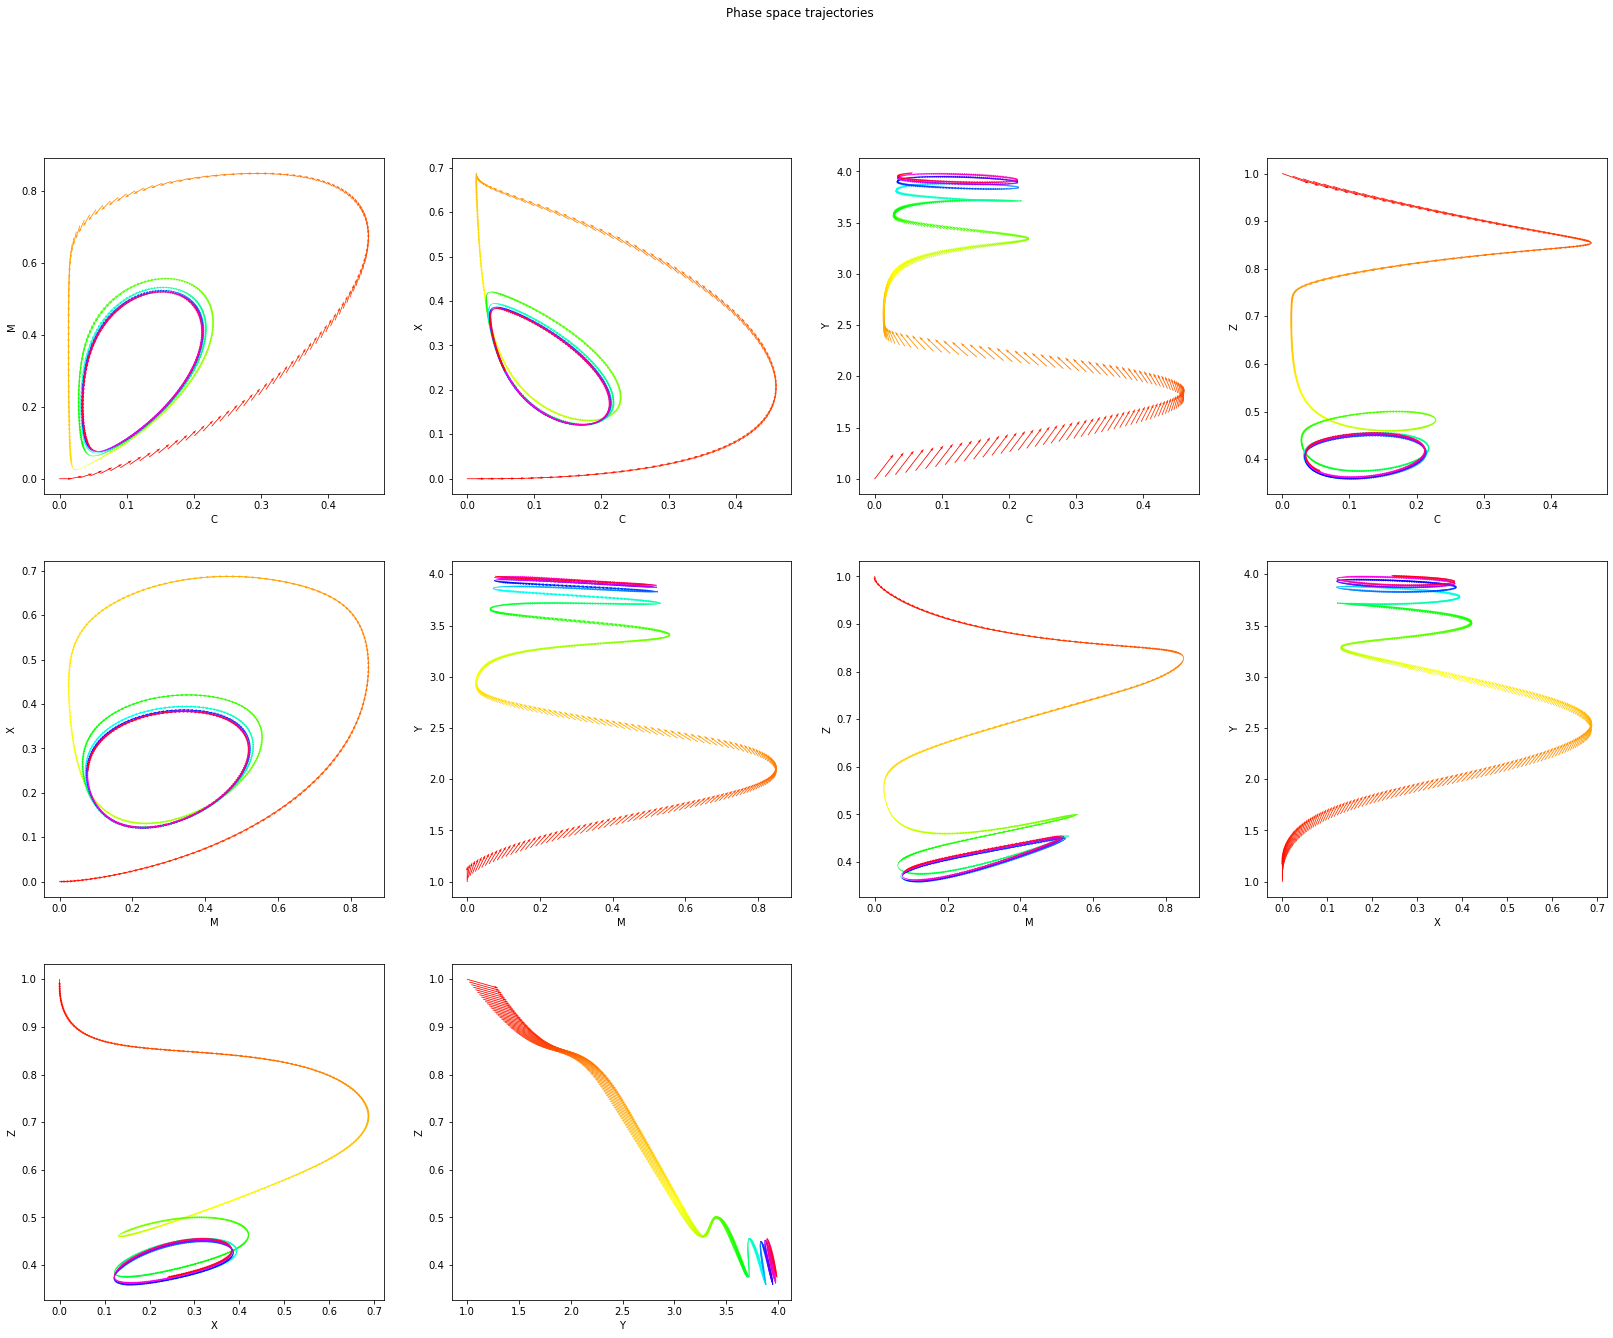

In [8]:
model, y0, w0 = load_model(8)
ys, ws, times = model(int(n_secs / model.deltaT))
plot_phase_space_trajectories(ys, model.modelstepfunc.y_indexes)

In [9]:
model, y0, w0 = load_model(8)
ys, ws, times = model(int(n_secs / model.deltaT))
ymin = ys.min(-1)
ymax = ys.max(-1)

batched_model = vmap(model, in_axes=(None, 0, 0), out_axes=(0, 0, None))
n_inits_per_dim = 3
n_inits = n_inits_per_dim ** len(ys)
init_type = "grid"

if init_type == "random":
    key = jrandom.PRNGKey(0)
    y0 = jrandom.uniform(key, (n_inits, len(y0))) * (ymax - ymin) + ymin
elif init_type == "grid":
    grid = jnp.meshgrid(
        *[
            jnp.linspace(ymin[node_idx], ymax[node_idx], n_inits_per_dim)
            for node_idx in range(len(ymin))
        ]
    )
    y0 = jnp.stack([dim_grid.flatten() for dim_grid in grid], axis=-1)

w0 = jnp.repeat(w0[jnp.newaxis], n_inits, axis=0)

ys, ws, times = batched_model(int(n_secs / model.deltaT), y0, w0)

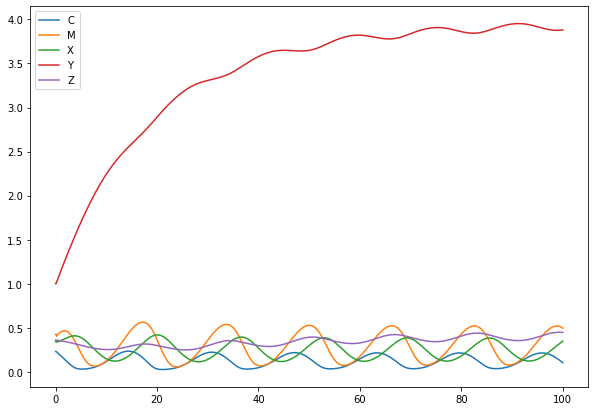

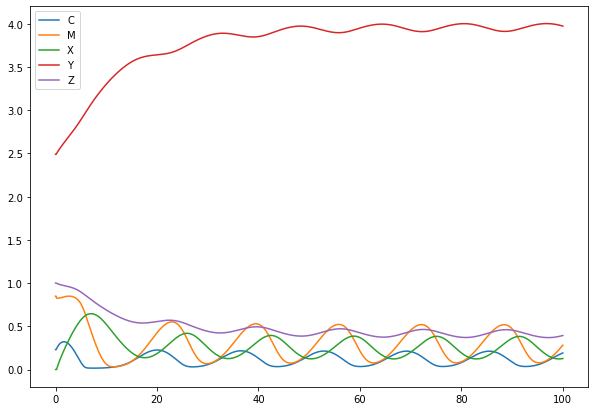

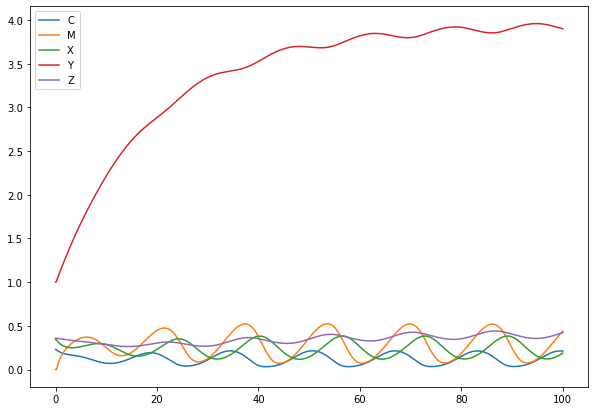

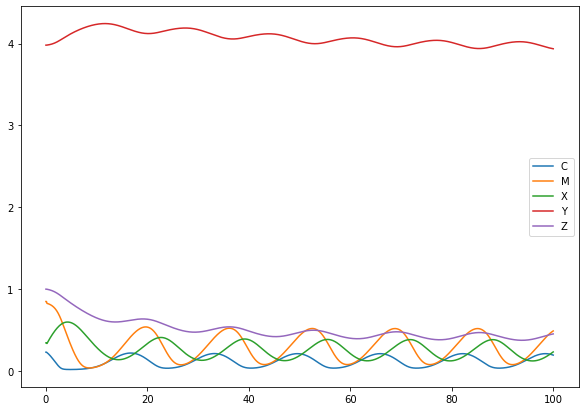

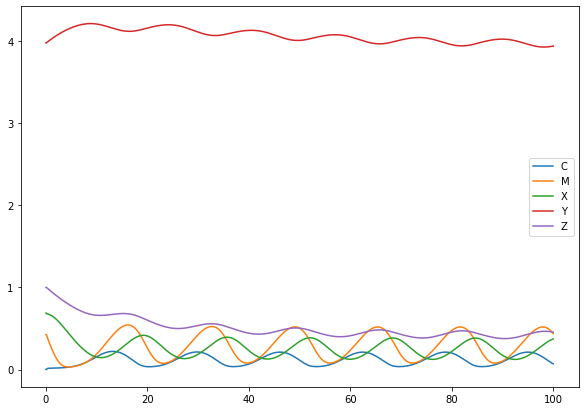

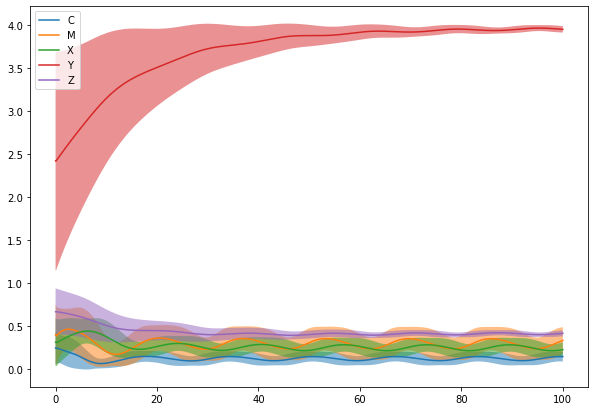

/tmp/ipykernel_20305/4085958686.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


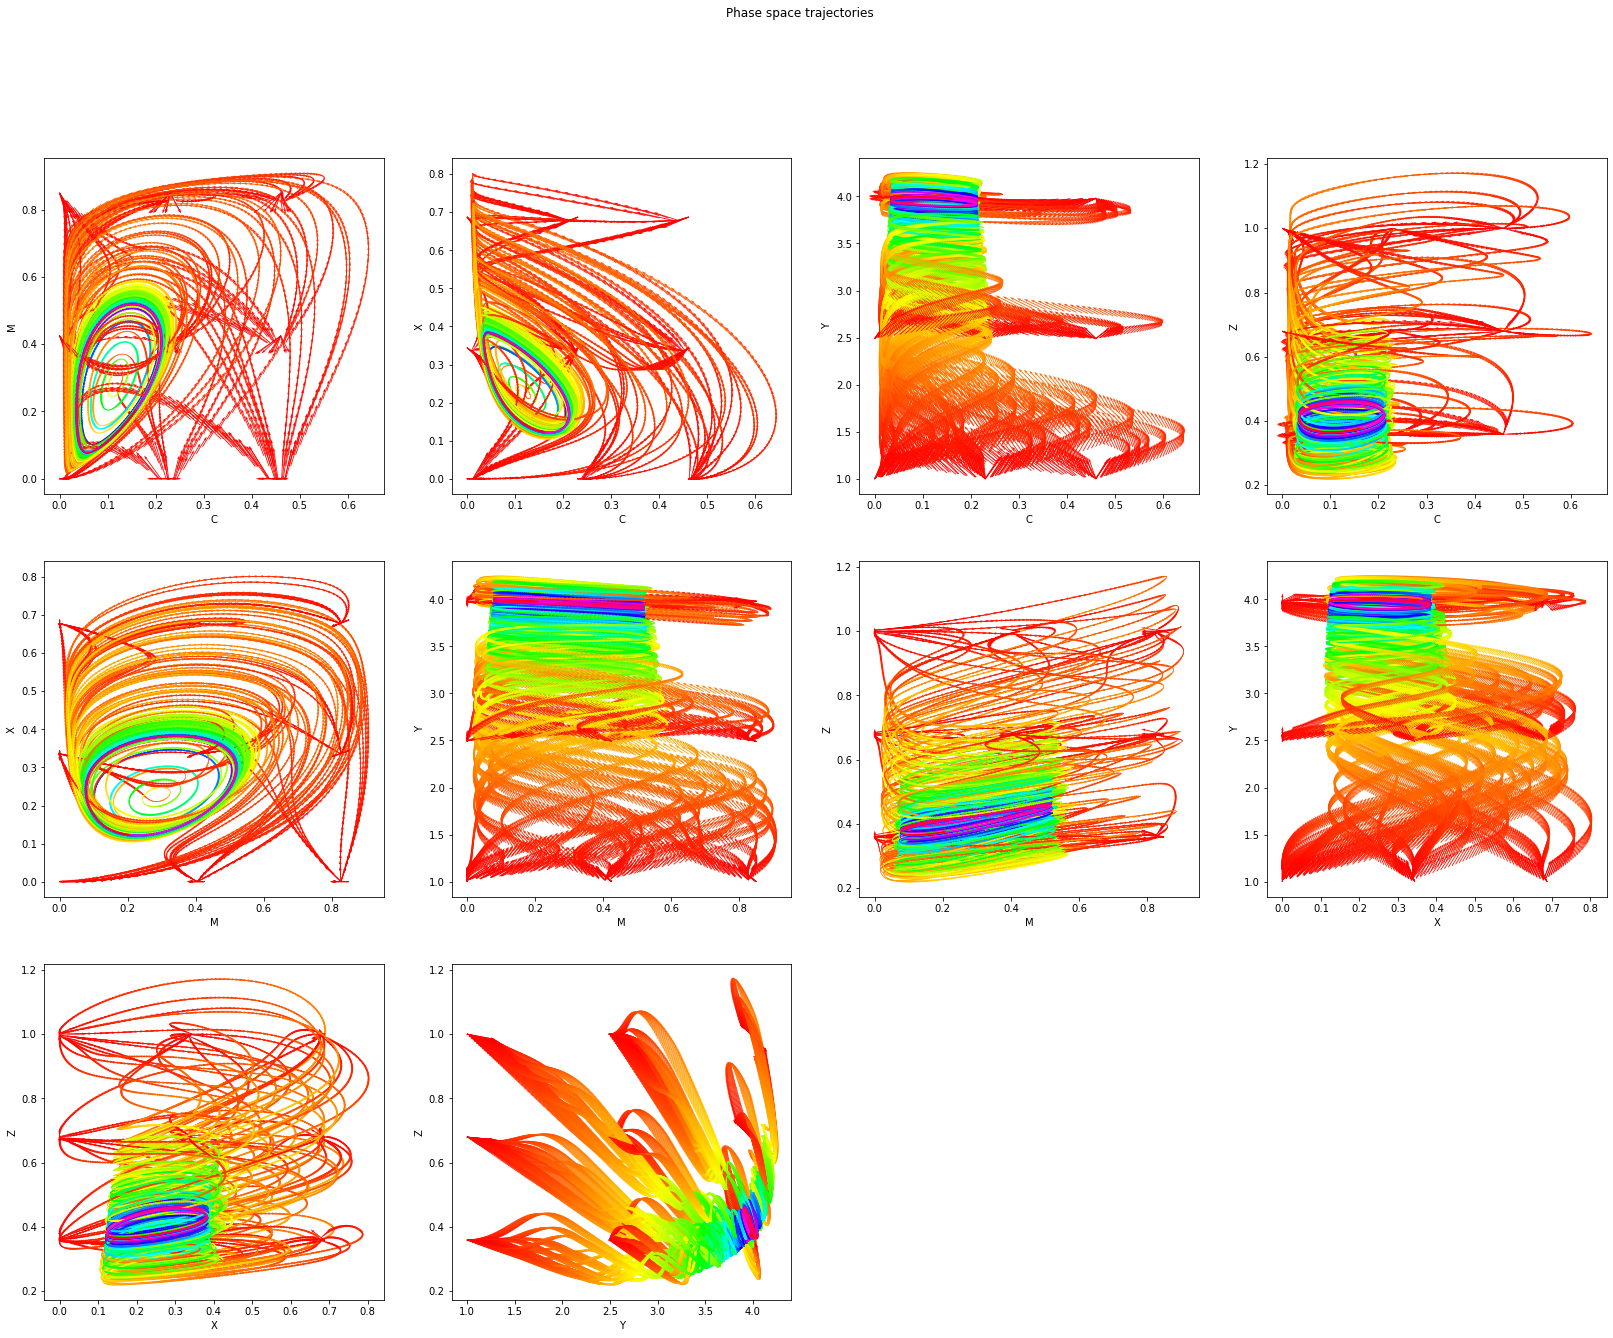

In [10]:
key = jrandom.PRNGKey(0)
sampled_ids = jrandom.choice(key, jnp.arange(len(ys)), shape=(100,), replace=False)
for i in range(5):
    plot_time_trajectories(
        times,
        ys[sampled_ids[i]],
        list(model.modelstepfunc.y_indexes.values()),
        list(model.modelstepfunc.y_indexes.keys()),
    )
plot_batched_phase_space_trajectories(ys[sampled_ids], model.modelstepfunc.y_indexes)

## Analysis of Model 84

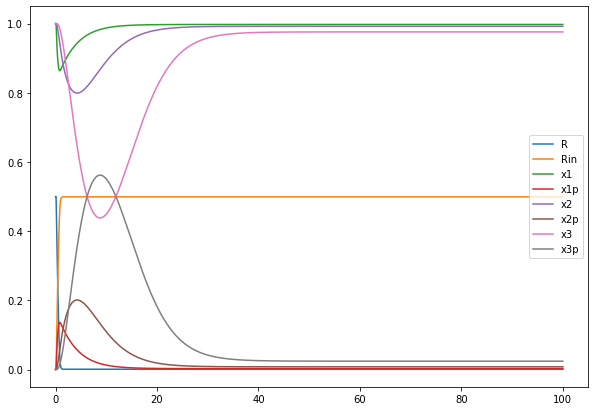

/tmp/ipykernel_20305/1213235191.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


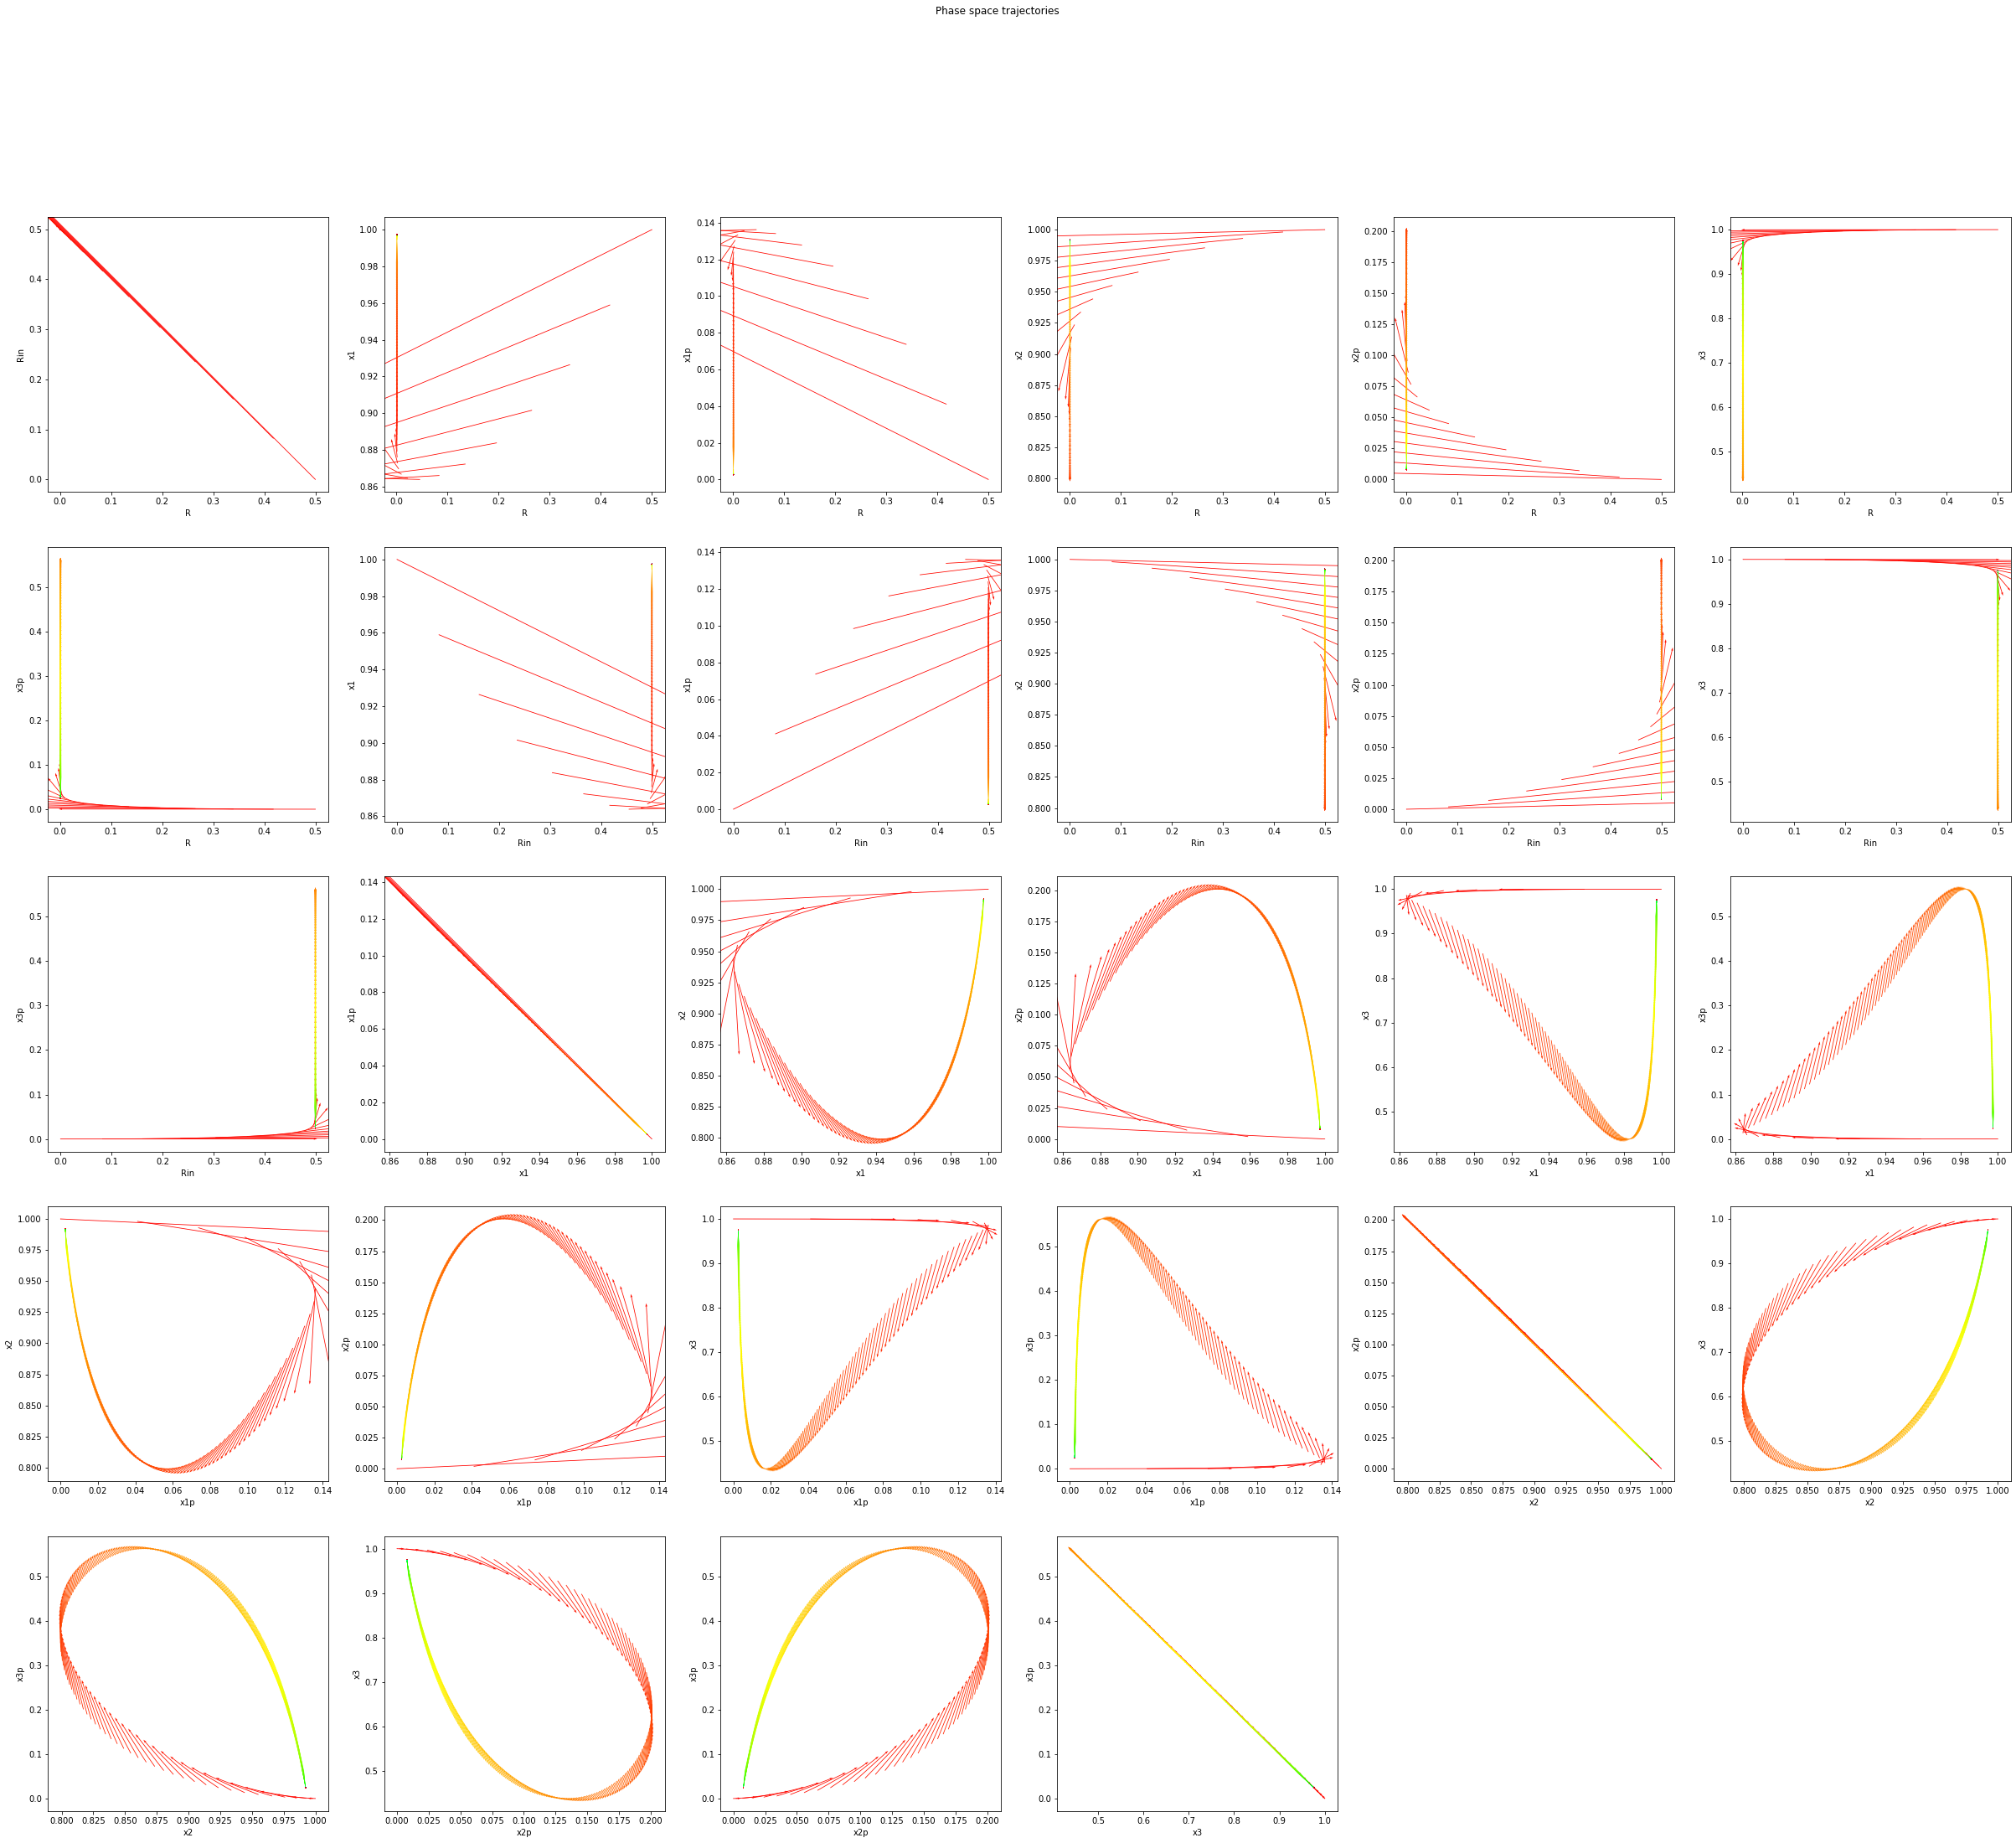

In [11]:
model, y0, w0 = load_model(84)
ys, ws, times = model(int(n_secs / model.deltaT))
plot_phase_space_trajectories(ys, model.modelstepfunc.y_indexes)

In [12]:
model, y0, w0 = load_model(84)
ys, ws, times = model(int(n_secs / model.deltaT))
ymin = ys.min(-1)
ymax = ys.max(-1)

batched_model = vmap(model, in_axes=(None, 0, 0), out_axes=(0, 0, None))
n_inits_per_dim = 3
n_inits = n_inits_per_dim ** len(ys)
init_type = "grid"

if init_type == "random":
    key = jrandom.PRNGKey(0)
    y0 = jrandom.uniform(key, (n_inits, len(y0))) * (ymax - ymin) + ymin
elif init_type == "grid":
    grid = jnp.meshgrid(
        *[
            jnp.linspace(ymin[node_idx], ymax[node_idx], n_inits_per_dim)
            for node_idx in range(len(ymin))
        ]
    )
    y0 = jnp.stack([dim_grid.flatten() for dim_grid in grid], axis=-1)

w0 = jnp.repeat(w0[jnp.newaxis], n_inits, axis=0)

ys, ws, times = batched_model(int(n_secs / model.deltaT), y0, w0)

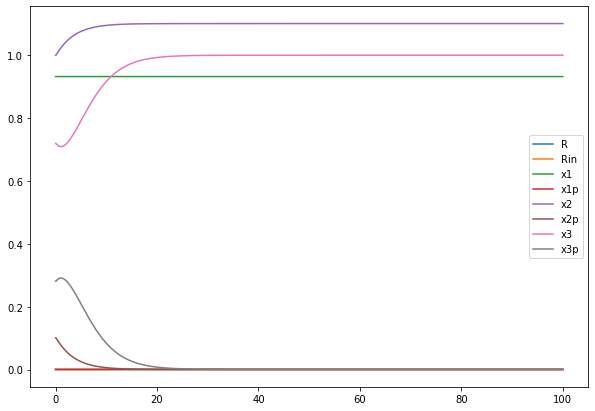

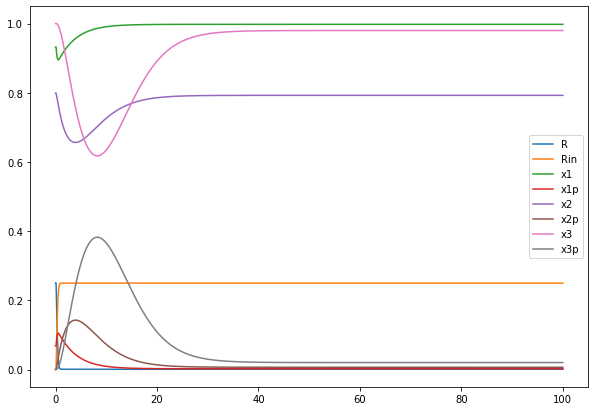

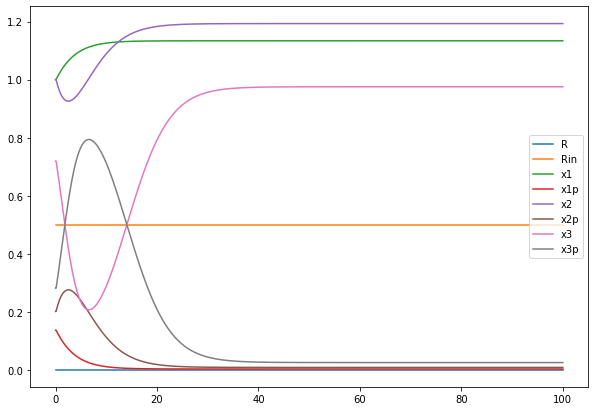

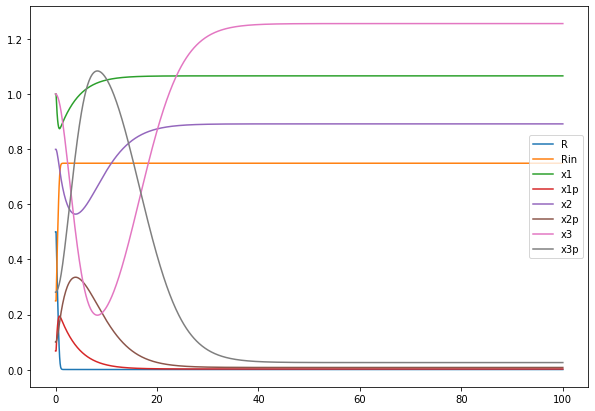

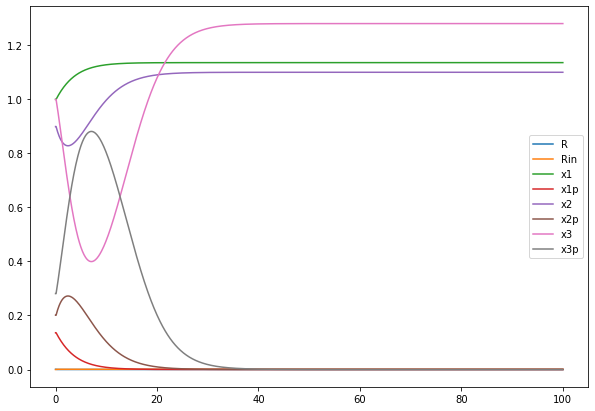

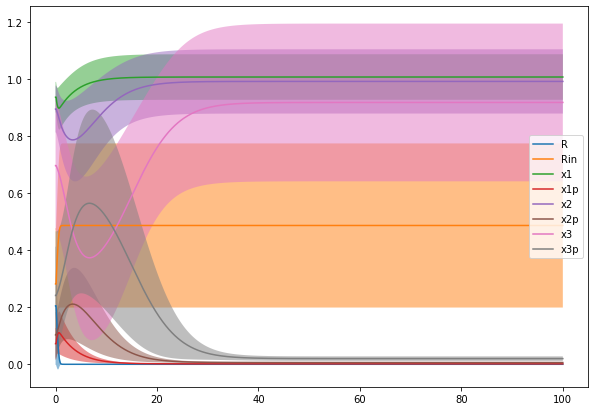

/tmp/ipykernel_20305/4085958686.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/mayalen/miniconda3/envs/grn/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/mayalen/miniconda3/envs/grn/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


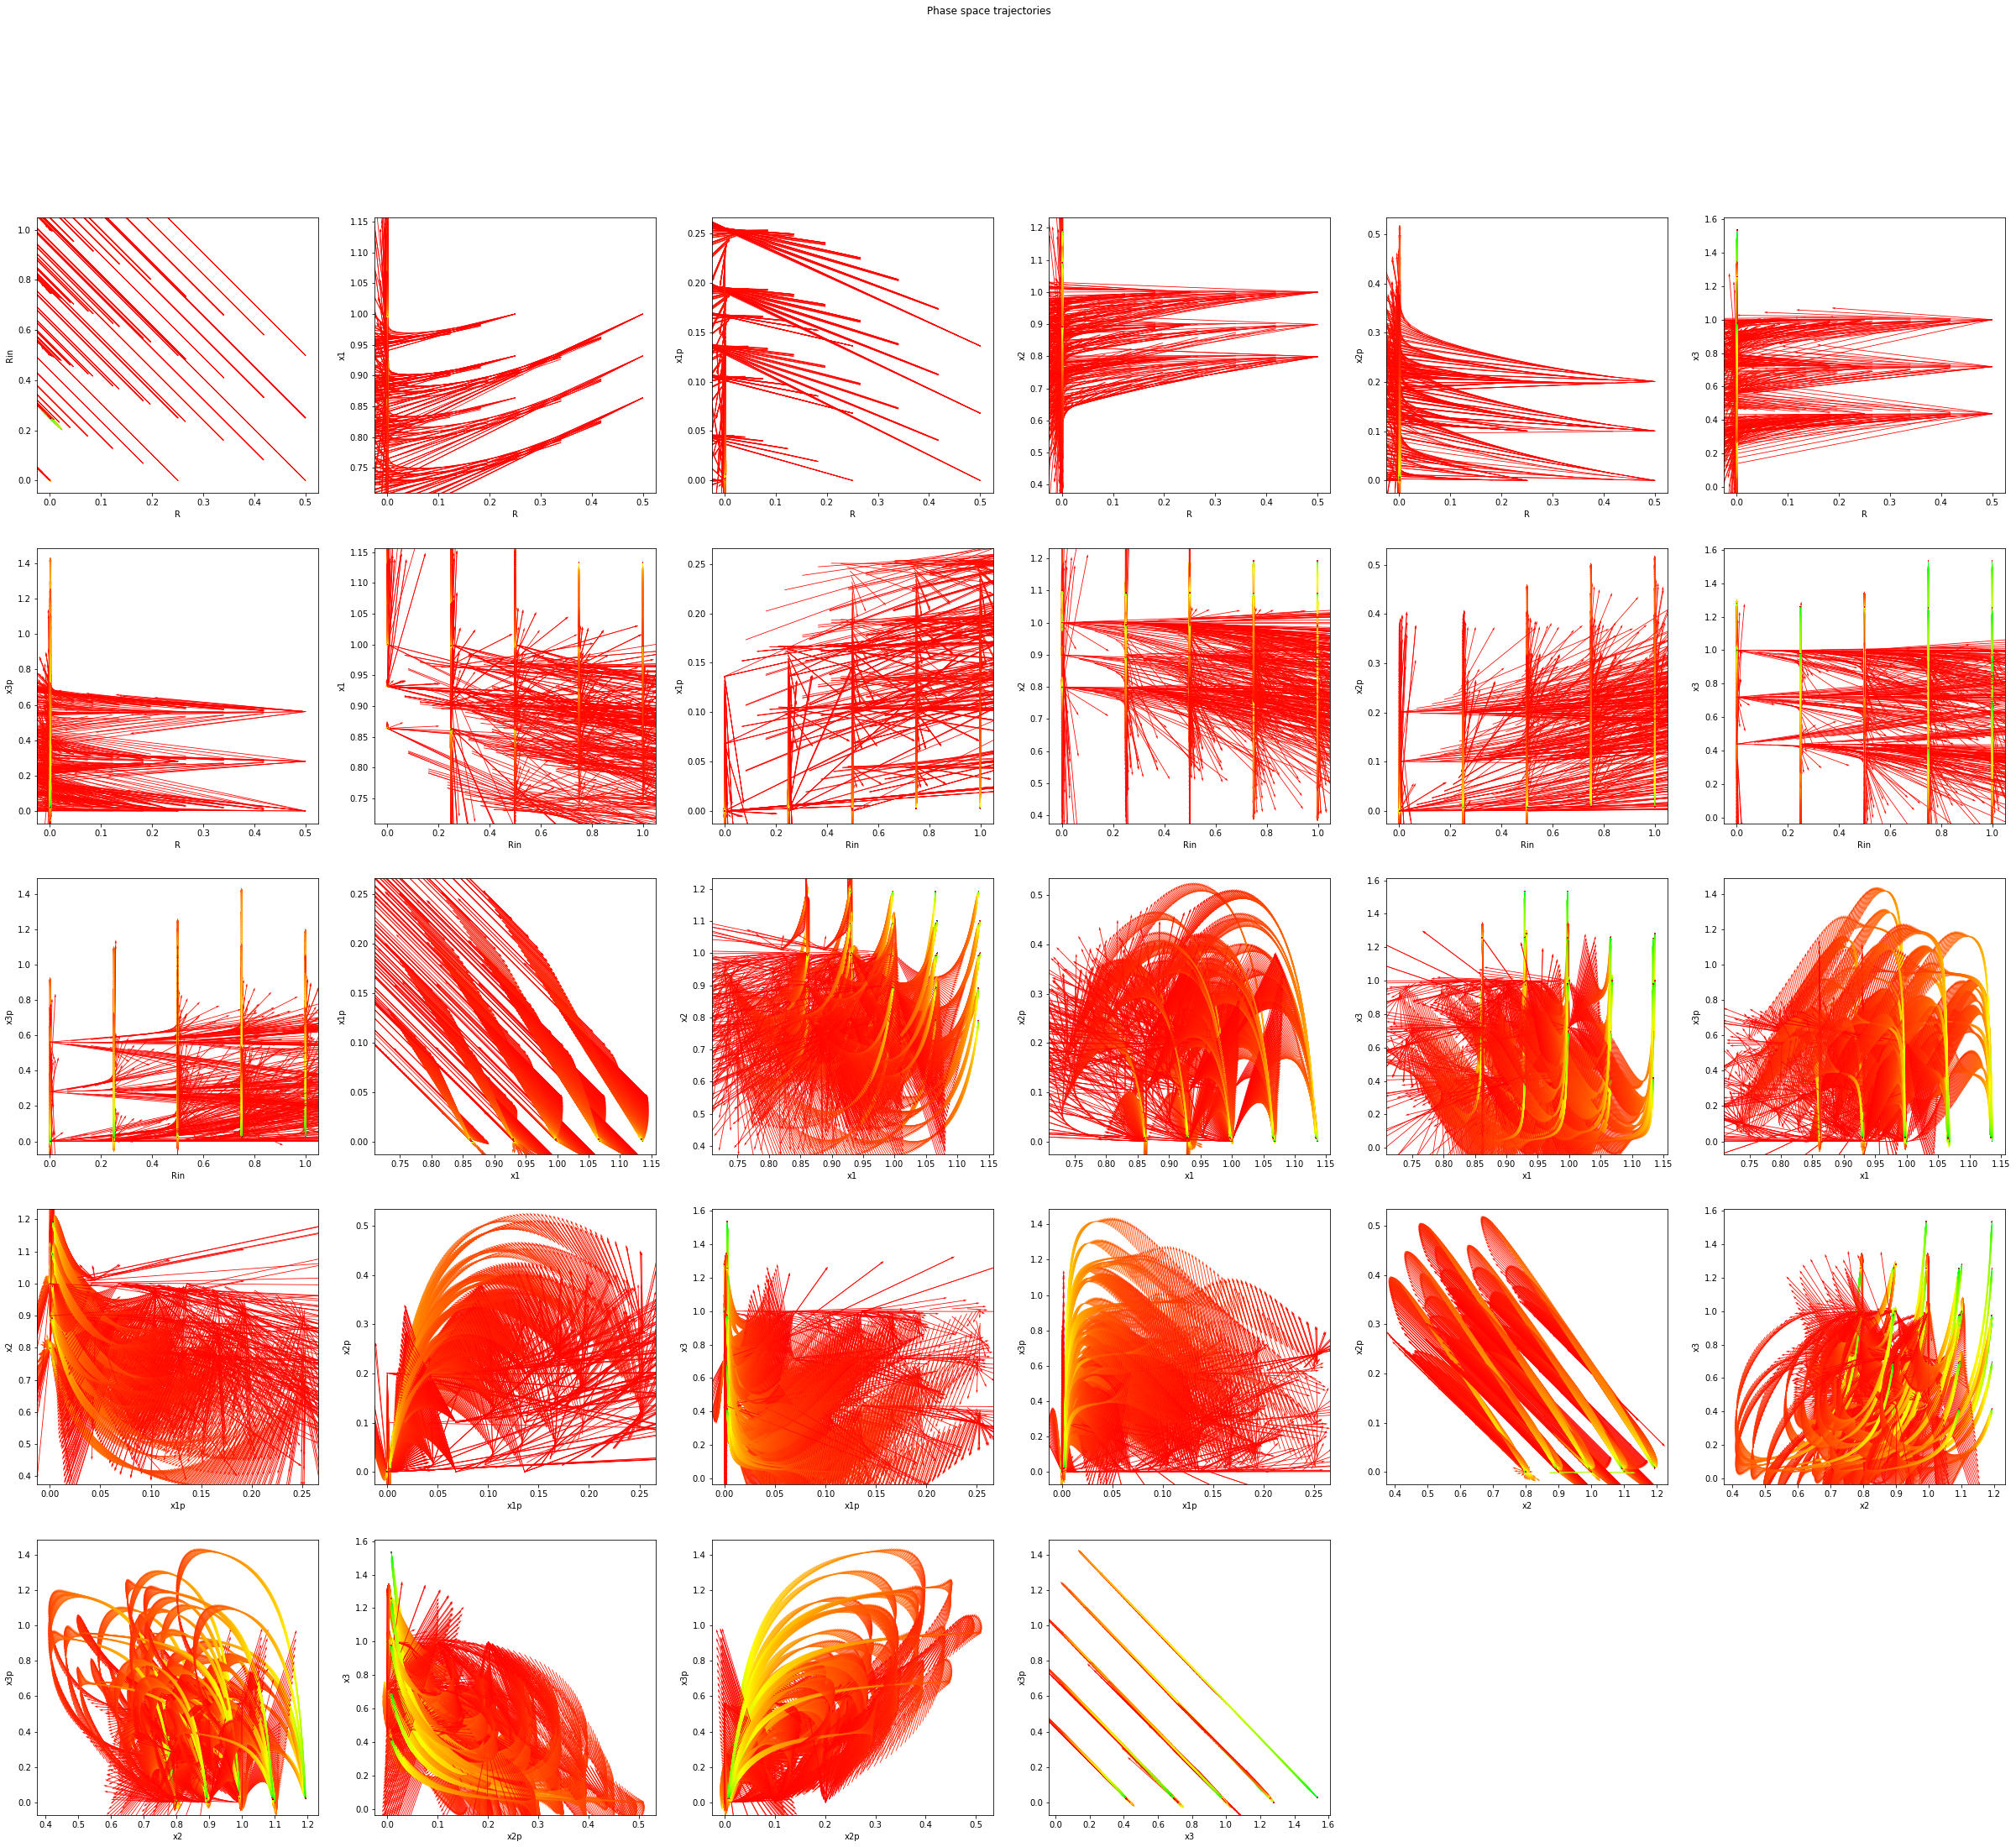

In [13]:
key = jrandom.PRNGKey(0)
sampled_ids = jrandom.choice(key, jnp.arange(len(ys)), shape=(100,), replace=False)
for i in range(5):
    plot_time_trajectories(
        times,
        ys[sampled_ids[i]],
        list(model.modelstepfunc.y_indexes.values()),
        list(model.modelstepfunc.y_indexes.keys()),
    )
plot_batched_phase_space_trajectories(ys[sampled_ids], model.modelstepfunc.y_indexes)